# MOS Spectroscopy of Extragalactic Field

**Use case:** emission-line measurements and template matching on 1D spectra.<br>
**Data:** CEERS NIRSpec observations<br>
**Tools:**  specutils, astropy, matplotlib, jdaviz.<br>
**Cross-intrument:** <br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis).<br>

## Introduction

In this notebook, we will inspect a set of spectra and perform a seris of spectroscopic analyses on an example spectrum, including continuum fitting and subtraction, line identification, centroiding and flux measurements, gaussian fitting, equivalent widths, and template fitting. We will do so using the interactive [jdaviz package](https://github.com/spacetelescope/jdaviz) and the command line. We will use a JWST/NIRSpec spectroscopic dataset from the [CEERS program](https://ceers.github.io/index.html).

### Objective of the notebook
The aim of the notebook is to showcase how to use the visualization tool Jdaviz or the combination Specutils+Matplotlib to measure the properties of the OII emission line in a NIRSpec spectrum.

### Workflow
- visualize the spectroscopic dataset in Mosviz
- select one galaxy (s02904) and visualize it in Specviz2d
- perform the 1D extraction of the bright companion using the Spectral Extraction plugin in Specviz2d
- attach the wavelength axis to the extracted 1D spectrum
- select the OII emission line and measure
    - the redshift of the source
    - the properties of the emission line
- fit a model with continuum + a Gaussian to the OII emission line
- perform the same tasks using Specutils and Matplotlib instead of Jdaviz
- find the best-fitting template of the observed spectrum

### System requirements
First, we create an environment with jdaviz which contains all the spectroscopic packages we need.

`conda create -n jdaviz python`<br>
`conda activate jdaviz`<br>
`pip install jdaviz`

## Imports

In [1]:
# general os
import zipfile
import urllib.request
from pathlib import Path

# general plotting
from matplotlib import pyplot as plt

# table/math handling
import numpy as np

# astropy
import astropy
import astropy.units as u
from astropy.io import fits, ascii
from astropy.nddata import StdDevUncertainty
from astropy.modeling import models
from astropy.visualization import quantity_support

# specutils
import specutils
from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum
from specutils.fitting import find_lines_threshold
from specutils.fitting import fit_lines
from specutils.manipulation import extract_region
from specutils.analysis import centroid
from specutils.analysis import line_flux
from specutils.analysis import equivalent_width
from specutils.analysis import template_comparison

# jdaviz
import jdaviz
from jdaviz import Mosviz, Specviz2d, Specviz  # noqa

# glue
from glue.core.roi import XRangeROI

np.seterr(all='ignore')  # hides irrelevant warnings about divide-by-zero, etc
quantity_support()  # auto-recognizes units on matplotlib plots

# Matplotlib parameters
params = {'legend.fontsize': '18', 
          'axes.labelsize': '18',
          'axes.titlesize': '18', 
          'xtick.labelsize': '18',
          'ytick.labelsize': '18', 
          'lines.linewidth': 2, 
          'axes.linewidth': 2, 
          'animation.html': 'html5'}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

## Check versions. Should be:

Numpy:  1.25.2<br>
Astropy:  5.3.2<br>
Specutils:  1.11.0<br>
Jdaviz: 3.7

In [2]:
print("Numpy: ", np.__version__)
print("Astropy: ", astropy.__version__)
print("Specutils: ", specutils.__version__)
print("Jdaviz: ", jdaviz.__version__)

Numpy:  1.26.1
Astropy:  5.3.4
Specutils:  1.12.0
Jdaviz:  3.7.0


## Set path to data and download from box link

In [3]:
# Download the data from the old version of this notebook. They include the templates for fitting
boxlink = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/mos_spectroscopy/mos_spectroscopy.zip'
boxfile = Path('./mos_spectroscopy.zip')
urllib.request.urlretrieve(boxlink, boxfile)

zf = zipfile.ZipFile(boxfile, 'r')
zf.extractall()

In [4]:
# Download the s2d and x1d files
boxlink_ceers = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/mos_spectroscopy/mos_ceers_data.zip'
boxfile_ceers = Path('./mos_ceers_data.zip')
urllib.request.urlretrieve(boxlink_ceers, boxfile_ceers)

zf = zipfile.ZipFile(boxfile_ceers, 'r')
zf.extractall()

**Developer note**:<br>
The download of JWST data could happen directly from MAST, but the observations are organized in separate folders, while Mosviz wants the data in a single folder. So we go with a box download.

In [5]:
# pathtodata = Path('/home/shared/preloaded-fits/jdaviz_data/mos_ceers_data')
pathtodata = Path('./data')

## Open data in Mosviz

In Mosviz we can explore all the data products in the folder. This cell takes a minute or two to run. Since we are not including images, we can expand the 2D/1D spectra viewers to use the full width of the GUI. We can also keep the plugin tray open on metadata to check specifics of the files we are looking at.

<img src='./mosviz_screenshot.png' alt="Mosviz with its 2D spectrum, 1D spectrum, and table viewer." width="900"/>

## Choose one galaxy

We choose s02904 because we want to extract the very bright companion below the target.

In [6]:
file1d = pathtodata / 'jw01345-o064_s02904_nirspec_f100lp-g140m_x1d.fits'
file2d = pathtodata / 'jw01345-o064_s02904_nirspec_f100lp-g140m_s2d.fits'

## Use Specviz2d to extract a better 1D spectrum

We open the Spectral Extraction plugin and select the appropriate trace (Polynomial, order 3, on pixel 2), background (Manual, on pixel 8, width 2, statistic average), and extraction (From Plugin, Horne). We then click Extract and inspect the extracted spectrum in the 1D viewer.

In [7]:
specviz2d = Specviz2d()
specviz2d.load_data(file2d)
specviz2d.show()

Application(config='specviz2d', docs_link='https://jdaviz.readthedocs.io/en/v3.7.0/specviz2d/index.html', even…

**Developer note**<br>
Is there a way to get out an uncertainty array from the extraction?<br>
This is being worked on.

In [8]:
# Get out extracted spectrum from Specviz2d
spectra = specviz2d.get_data('Spectrum 1D')
spectra

<Spectrum1D(flux=<Quantity [0., 0., 0., ..., 0., 0., 0.] MJy>, spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=0.0 km / s
      redshift=0.0)
  [0.96262388, 0.96262388, 0.96262388, ..., 1.89519827, 1.89583322,
   1.89583322] um>)>

In [9]:
# Include some fake uncertainty for now
spec1d = Spectrum1D(spectral_axis=spectra.spectral_axis,
                    flux=spectra.flux,
                    uncertainty=StdDevUncertainty((np.zeros(len(spectra.flux)) + 1E-13) * spectra.unit))
spec1d

<Spectrum1D(flux=<Quantity [0., 0., 0., ..., 0., 0., 0.] MJy>, spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=0.0 km / s
      redshift=0.0)
  [0.96262388, 0.96262388, 0.96262388, ..., 1.89519827, 1.89583322,
   1.89583322] um>, uncertainty=StdDevUncertainty([1.e-13, 1.e-13, 1.e-13, ..., 1.e-13, 1.e-13, 1.e-13]))>

In [10]:
# And open in Specviz
specviz = Specviz()
specviz.load_data(spec1d, data_label='spec1d calibrated')
specviz.show()

Application(config='specviz', docs_link='https://jdaviz.readthedocs.io/en/v3.7.0/specviz/index.html', events=[…

There are still some artifacts in the data, but we can select a subset masking the artifacts and get out a spectrum without unwanted spikes. We can do so using the tool to select a subset with the "add" option (in the top bar) to select multiple regions as part of a single subset.

In [11]:
# Create a subset in the area of interest if it has not been created manually
try:
    region1 = specviz.get_data(data_label='spec1d calibrated', spectral_subset='Subset 1')
    print(region1)
    region1_exists = True
except Exception:
    print("There are no subsets selected.")
    region1_exists = False
    
# Spectral region for masking artifacts
if not region1_exists:
    sv = specviz.app.get_viewer('spectrum-viewer')
    sv.toolbar_active_subset.selected = []
    sv.apply_roi(XRangeROI(1., 1.58))  

There are no subsets selected.


In [12]:
# Get spectrum out with mask
spec1d_region = specviz.get_spectral_regions()
spec1d_masked = extract_region(spec1d, spec1d_region['Subset 1'], return_single_spectrum=True)

In [13]:
# Load in specviz
specviz.load_data(spec1d_masked, data_label='spec1d masked')

In [14]:
# Write the extracted spectrum to a fits file
file_extracted = Path('./extracted_spectrum.fits')
spec1d_masked.write(file_extracted, overwrite=True)

In [15]:
# Check that it has everything
hdu = fits.open(file_extracted)
hdu.info()

Filename: extracted_spectrum.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     17   911R x 3C   [D, D, D]   


In [16]:
hdu[1].data

FITS_rec([(1.00020414, 2.20226191e-13, 1.e-13),
          (1.0008411 , 7.11024936e-14, 1.e-13),
          (1.00149188, 3.35875760e-13, 1.e-13),
          (1.00212885, 2.73494495e-13, 1.e-13),
          (1.00276581, 2.33289362e-13, 1.e-13),
          (1.00340278, 2.08752581e-13, 1.e-13),
          (1.00403974, 3.60731324e-13, 1.e-13),
          (1.00467671, 2.91254772e-13, 1.e-13),
          (1.00531368, 3.54084183e-13, 1.e-13),
          (1.00595064, 1.58528613e-13, 1.e-13),
          (1.00658761, 1.00099923e-13, 1.e-13),
          (1.00722458, 1.93899402e-13, 1.e-13),
          (1.00786154, 2.71433068e-13, 1.e-13),
          (1.00849851, 5.44897721e-13, 1.e-13),
          (1.00913548, 2.77380637e-13, 1.e-13),
          (1.00977245, 5.20373636e-13, 1.e-13),
          (1.01040941, 3.18918981e-13, 1.e-13),
          (1.01104638, 2.26125943e-13, 1.e-13),
          (1.01168335, 3.19381799e-13, 1.e-13),
          (1.01232032, 3.14886887e-13, 1.e-13),
          (1.01295729, 2.44143994e-13, 1

## Workflow via API calls

I can do some analysis on the spectrum using the plugins in the GUI. For reproducibility, I can do the same thing from the API, changing the parameters in the plugins programmatically.

In [17]:
# Select a region in the spectrum
sv = specviz.app.get_viewer('spectrum-viewer')

In [18]:
# Region with just line for line analysis
sv.toolbar_active_subset.selected = []
sv.apply_roi(XRangeROI(1.124, 1.131))  

In [19]:
# Region with some continuum for gaussian fit
sv.toolbar_active_subset.selected = []
sv.apply_roi(XRangeROI(1.05, 1.25))  

In [20]:
# Open line analysis plugin
plugin_la = specviz.plugins['Line Analysis']
plugin_la.open_in_tray()

In [21]:
# List what is in the data menu
[d.label for d in specviz.app.data_collection]

['spec1d calibrated', 'spec1d masked']

In [22]:
# Input the appropriate spectrum and region
plugin_la.dataset = 'spec1d masked'
plugin_la.spectral_subset = 'Subset 2'

In [23]:
# Input the values for the continuum
plugin_la.continuum = 'Surrounding'
plugin_la.width = 7

In [24]:
# Return line analysis results
plugin_la.get_results()

[{'function': 'Line Flux', 'result': ''},
 {'function': 'Equivalent Width', 'result': ''},
 {'function': 'Gaussian Sigma Width', 'result': ''},
 {'function': 'Gaussian FWHM', 'result': ''},
 {'function': 'Centroid', 'result': ''}]

In [25]:
# Open line list plugin
plugin_ll = specviz.plugins['Line Lists']
plugin_ll.open_in_tray()

**Developer note**<br>
The line list plugin cannot yet be accessed by the notebook. I can do it in the GUI though.

Open line list plugin. Select the SDSS IV line list. Load the Oxygen II lines and Hb. Go back to line analysis plugin and associate the Oxygen II line with the line we just analyzed.

In [26]:
# Open model fitting plugin
plugin_mf = specviz.plugins['Model Fitting']
plugin_mf.open_in_tray()

In [27]:
# Input the appropriate datasets
plugin_mf.dataset = 'spec1d masked'
plugin_mf.spectral_subset = 'Subset 3'

In [28]:
# Input the model components
plugin_mf.create_model_component(model_component='Polynomial1D',
                                 poly_order=2,
                                 model_component_label='P2')
plugin_mf.create_model_component(model_component='Gaussian1D',
                                 model_component_label='G')

In [29]:
plugin_mf.get_model_component('G')

{'model_type': 'Gaussian1D',
 'parameters': {'amplitude': {'value': 9.28889869794063e-13,
   'unit': 'MJy',
   'std': nan,
   'fixed': False},
  'mean': {'value': 1.1695679004508002,
   'unit': 'um',
   'std': nan,
   'fixed': False},
  'stddev': {'value': 0.04850103358252829,
   'unit': 'um',
   'std': nan,
   'fixed': False}}}

In [30]:
plugin_mf.set_model_component('G', 'stddev', 0.001)
plugin_mf.set_model_component('G', 'mean', 1.128)

{'name': 'mean', 'value': 1.128, 'unit': 'um', 'fixed': False}

In [31]:
# Model equation gets populated automatically
plugin_mf.equation = 'P2+G'

In [32]:
# After we run this, we go to the GUI and check that the fit makes sense
plugin_mf.calculate_fit()

(<CompoundModel(c0_0=-0. MJy, c1_0=0. MJy / um, c2_0=-0. MJy / um2, amplitude_1=0. MJy, mean_1=1.12768736 um, stddev_1=0.00080151 um)>,
 <Spectrum1D(flux=<Quantity [1.80438071e-14, 2.05798791e-14, 2.31691865e-14, 2.57017954e-14,
            2.82326888e-14, 3.07618668e-14, 3.32893293e-14, 3.58150762e-14,
            3.83391077e-14, 4.08614236e-14, 4.33820239e-14, 4.59009087e-14,
            4.84180779e-14, 5.09335315e-14, 5.34472696e-14, 5.59592920e-14,
            5.84695987e-14, 6.09781898e-14, 6.34850653e-14, 6.59902250e-14,
            6.84936691e-14, 7.09953975e-14, 7.34954101e-14, 7.59937070e-14,
            7.84902882e-14, 8.09851536e-14, 8.34783032e-14, 8.59697371e-14,
            8.85135659e-14, 9.10015357e-14, 9.34877897e-14, 9.59723278e-14,
            9.84551501e-14, 1.00936256e-13, 1.03415647e-13, 1.05893322e-13,
            1.08369280e-13, 1.10843523e-13, 1.13316050e-13, 1.15786861e-13,
            1.18255955e-13, 1.20723334e-13, 1.23188997e-13, 1.25652944e-13,
           

In [33]:
specviz.get_model_parameters()

{'spec1d masked model': {'c0_0': <Quantity -6.08179137e-12 MJy>,
  'c1_0': <Quantity 8.21432853e-12 MJy / um>,
  'c2_0': <Quantity -2.1153065e-12 MJy / um2>,
  'amplitude_1': <Quantity 8.29375554e-13 MJy>,
  'mean_1': <Quantity 1.12768736 um>,
  'stddev_1': <Quantity 0.00080151 um>}}

# Same workflow with specutils (old workflow)
The same workflow can be achieved using directly the package specutils (which is used under the hood in jdaviz) and using matplotlib for a static visualization.

## Fit and substract the continuum

In [34]:
cont_spec1d = fit_generic_continuum(spec1d_masked)
cont_fit = cont_spec1d(spec1d_masked.spectral_axis)

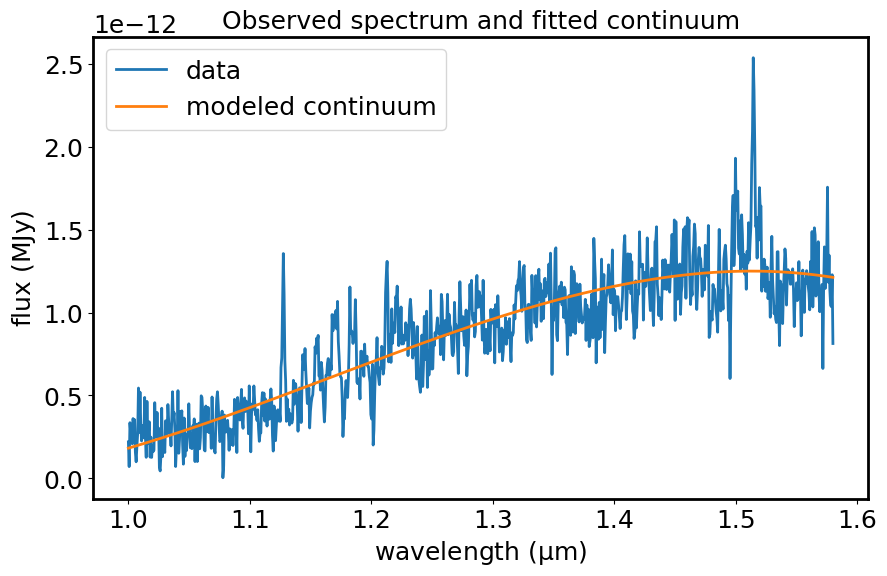

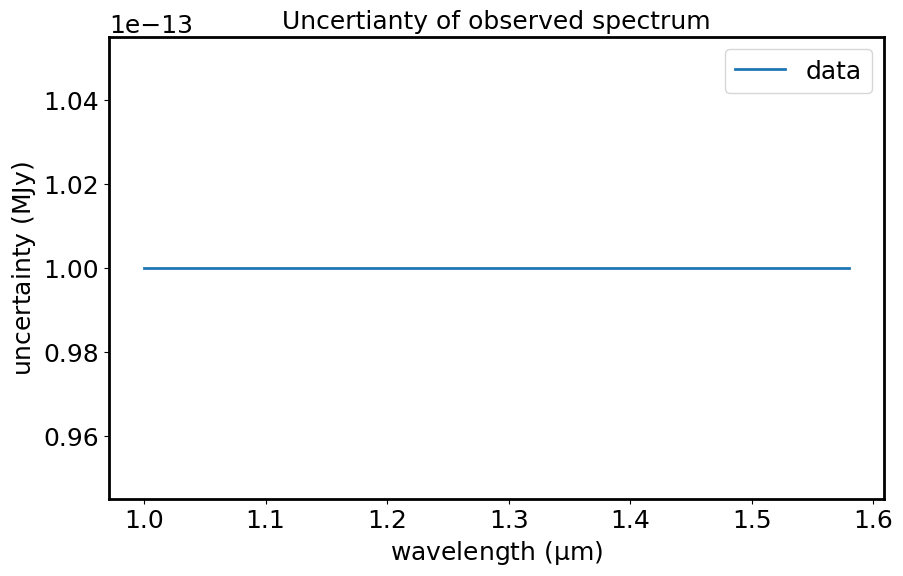

In [35]:
plt.figure(figsize=[10, 6])
plt.plot(spec1d_masked.spectral_axis, spec1d_masked.flux, label="data")
plt.plot(spec1d_masked.spectral_axis, cont_fit, label="modeled continuum")
plt.xlabel("wavelength ({:latex})".format(spec1d_masked.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_masked.flux.unit))
plt.legend()
plt.title("Observed spectrum and fitted continuum")
plt.show()

plt.figure(figsize=[10, 6])
plt.plot(spec1d_masked.spectral_axis, spec1d_masked.uncertainty.array, label="data")
plt.xlabel("wavelength ({:latex})".format(spec1d_masked.spectral_axis.unit))
plt.ylabel("uncertainty ({:latex})".format(spec1d_masked.uncertainty.unit))
plt.legend()
plt.title("Uncertianty of observed spectrum")
plt.show()

### Creating the continuum-subtracted spectrum
Specutils will figure out what to do with the uncertainty!

In [36]:
spec1d_sub = spec1d_masked - cont_fit
spec1d_sub

<Spectrum1D(flux=<Quantity [ 3.78879603e-14, -1.12600950e-13,  1.50774300e-13,
            8.70215826e-14,  4.54419306e-14,  1.95275767e-14,
            1.70125703e-13,  9.92655042e-14,  1.60708250e-13,
           -3.62369939e-14, -9.60583523e-14, -3.65452475e-15,
            7.24805189e-14,  3.44543589e-13,  7.56219757e-14,
            3.17207509e-13,  1.14342465e-13,  2.01361258e-14,
            1.11975782e-13,  1.06061781e-13,  3.38969237e-14,
            2.76521252e-13,  4.02614029e-14, -8.74602231e-14,
            2.48206458e-13, -8.94888135e-15,  5.44561545e-14,
            1.20981319e-13, -9.33895278e-14,  2.58685423e-14,
           -9.81067592e-14, -2.82739093e-14, -6.53101902e-14,
           -5.84699817e-14,  2.26110072e-13,  7.08433041e-14,
            1.60281399e-14,  1.62643651e-13,  1.67497793e-14,
            6.52841146e-14, -1.72963312e-13, -1.95748282e-13,
           -1.02741114e-13,  1.79284740e-13, -1.14398028e-13,
           -7.87035724e-15, -5.75966765e-14, -9.35714

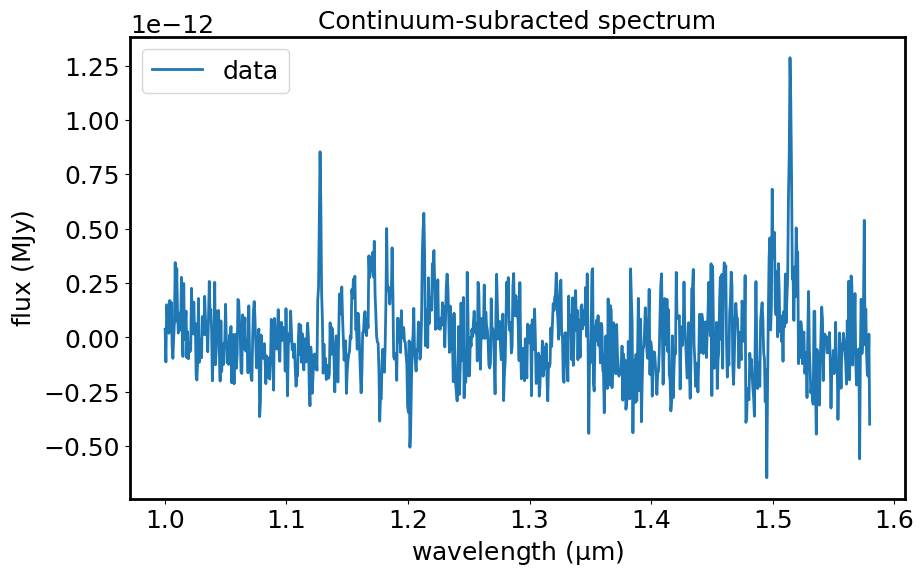

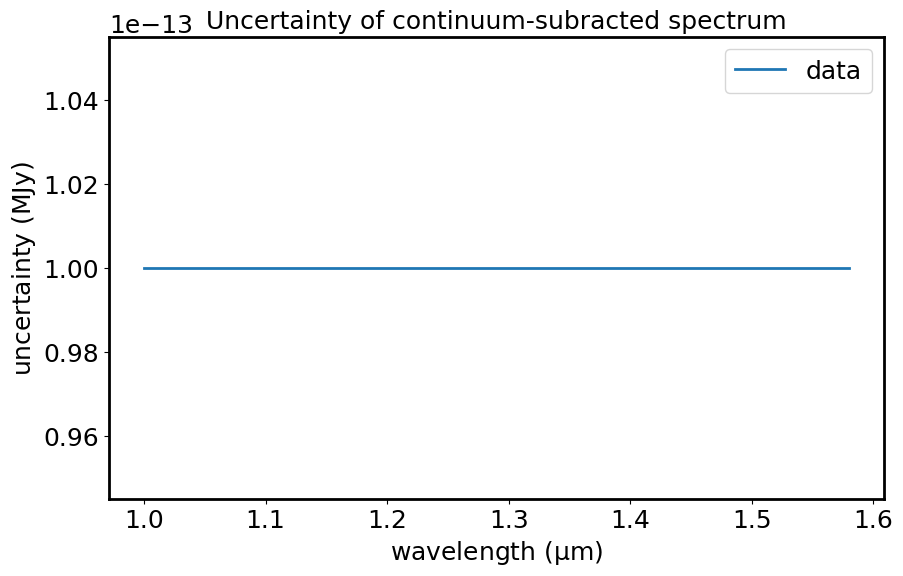

In [37]:
plt.figure(figsize=[10, 6])
plt.plot(spec1d_sub.spectral_axis, spec1d_sub.flux, label="data")
plt.xlabel("wavelength ({:latex})".format(spec1d_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_sub.flux.unit))
plt.legend()
plt.title("Continuum-subracted spectrum")
plt.show()

plt.figure(figsize=[10, 6])
plt.plot(spec1d_sub.spectral_axis, spec1d_sub.uncertainty.array, label="data")
plt.xlabel("wavelength ({:latex})".format(spec1d_sub.spectral_axis.unit))
plt.ylabel("uncertainty ({:latex})".format(spec1d_sub.uncertainty.unit))
plt.legend()
plt.title("Uncertainty of continuum-subracted spectrum")
plt.show()

## Find emission and absorption lines

In [38]:
lines = find_lines_threshold(spec1d_sub, noise_factor=3)
lines

line_center,line_type,line_center_index
um,,
float64,str10,int64
1.0084985099349837,emission,13
1.00977244535525,emission,15
1.1276681596792193,emission,200
1.167809998569554,emission,263
1.170994665048726,emission,268
1.1722685279834808,emission,270
1.1824593532966197,emission,286
1.1869177938992066,emission,293


Plot the emission lines on the spectrum.

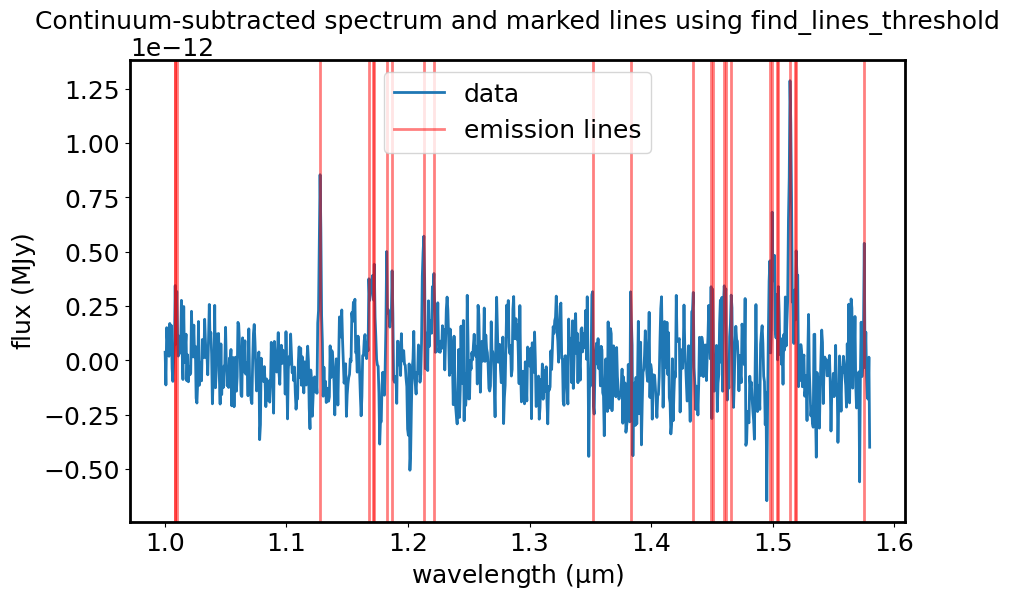

In [39]:
plt.figure(figsize=[10, 6])
plt.plot(spec1d_sub.spectral_axis, spec1d_sub.flux, label="data")
plt.axvline(lines['line_center'][0].value, color="red", alpha=0.5, label='emission lines')
for line in lines:
    if line['line_type'] == 'emission':
        plt.axvline(line['line_center'].value, color='red', alpha=0.5)
plt.xlabel("wavelength ({:latex})".format(spec1d_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_sub.flux.unit))
plt.legend()
plt.title("Continuum-subtracted spectrum and marked lines using find_lines_threshold")
plt.show()

Work by hand on a single line.

In [40]:
# Define limits for plotting
x_min = 1.1
x_max = 1.16

# Define limits for line region
line_min = 1.124*u.um
line_max = 1.131*u.um

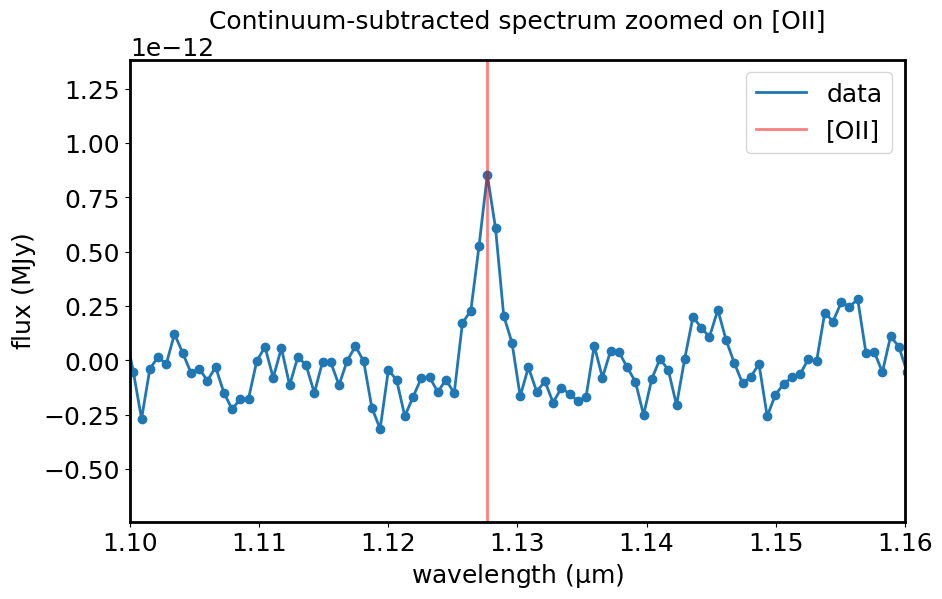

In [41]:
plt.figure(figsize=[10, 6])
plt.plot(spec1d_sub.spectral_axis, spec1d_sub.flux, label="data")
plt.scatter(spec1d_sub.spectral_axis, spec1d_sub.flux, label=None)
plt.axvline(lines['line_center'][0].value, color="red", alpha=0.5, label='[OII]')
for line in lines:
    if line['line_type'] == 'emission':
        plt.axvline(line['line_center'].value, alpha=0.5, color='red')
plt.xlim(x_min, x_max)
plt.xlabel("wavelength ({:latex})".format(spec1d_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_sub.flux.unit))
plt.legend()
plt.title("Continuum-subtracted spectrum zoomed on [OII]")
plt.show()

## Measure line centroids and fluxes

In [42]:
# Example with just one line
centroid(spec1d_sub, SpectralRegion(line_min, line_max))

<Quantity 1.12766758 um>

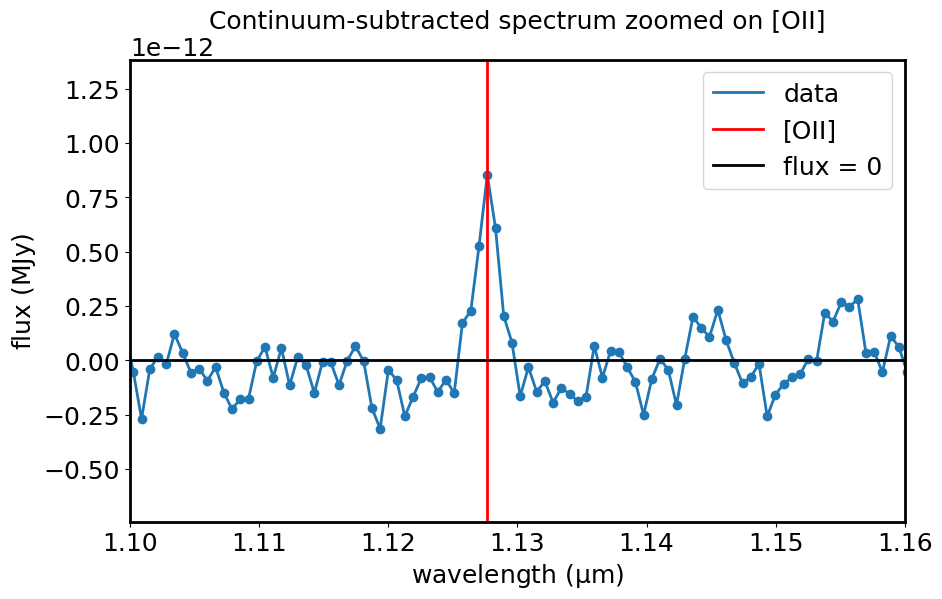

In [43]:
sline = centroid(spec1d_sub, SpectralRegion(line_min, line_max))

plt.figure(figsize=[10, 6])
plt.plot(spec1d_sub.spectral_axis, spec1d_sub.flux, label="data")
plt.scatter(spec1d_sub.spectral_axis, spec1d_sub.flux, label=None)
plt.axvline(sline.value, color='red', label="[OII]")
plt.axhline(0, color='black', label='flux = 0')
plt.xlim(x_min, x_max)
plt.xlabel("wavelength ({:latex})".format(spec1d_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_sub.flux.unit))
plt.legend()
plt.title("Continuum-subtracted spectrum zoomed on [OII]")
plt.show()

In [44]:
line_flux(spec1d_sub, SpectralRegion(line_min, line_max))  

<Quantity 1.43185615e-15 MJy um>

## Fit the line with a Gaussian

In [45]:
g_init = models.Gaussian1D(mean=1.1278909*u.um, stddev=0.001*u.um)
g_fit = fit_lines(spec1d_sub, g_init)
spec1d_fit = g_fit(spec1d_sub.spectral_axis)
g_fit

<Gaussian1D(amplitude=0. MJy, mean=1.12769107 um, stddev=0.00078611 um)>

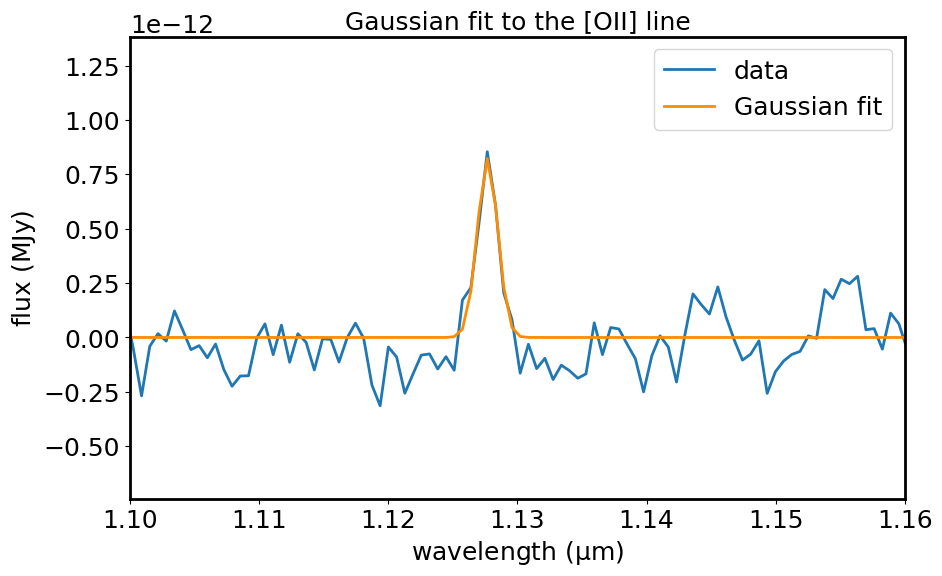

In [46]:
plt.figure(figsize=[10, 6])
plt.plot(spec1d_sub.spectral_axis, spec1d_sub.flux, label='data')
plt.plot(spec1d_sub.spectral_axis, spec1d_fit, color='darkorange', label='Gaussian fit')
plt.xlim(x_min, x_max)
plt.xlabel("wavelength ({:latex})".format(spec1d_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_sub.flux.unit))
plt.legend()
plt.title('Gaussian fit to the [OII] line')
plt.show()

## Measure the equivalent width of the lines
This needs the spectrum continuum normalized.

In [47]:
spec1d_norm = spec1d_masked / cont_fit

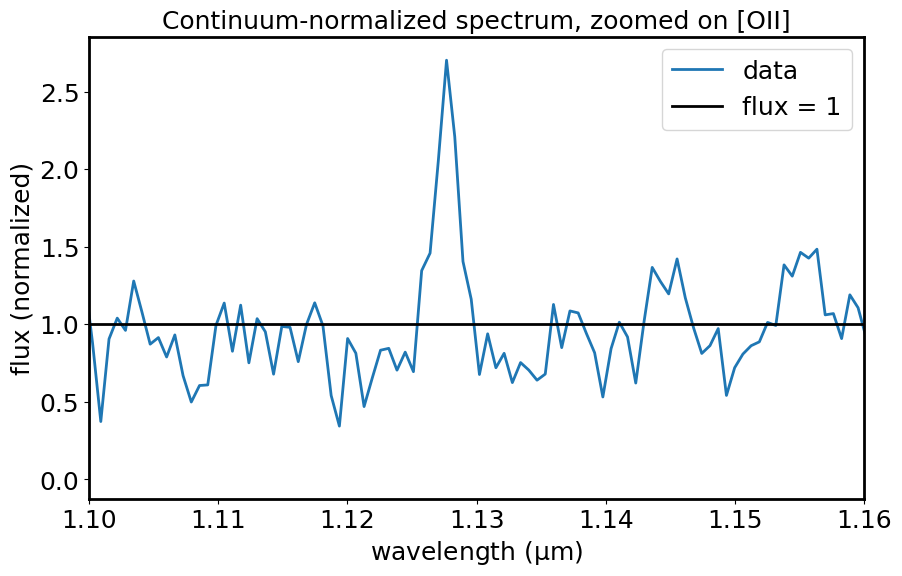

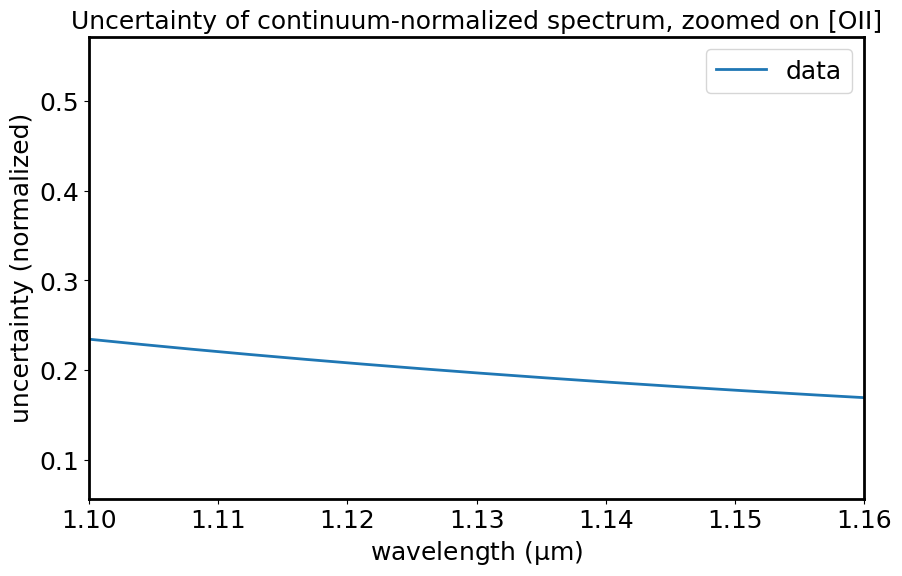

In [48]:
plt.figure(figsize=[10, 6])
plt.plot(spec1d_norm.spectral_axis, spec1d_norm.flux, label='data')
plt.axhline(1, color='black', label='flux = 1')
plt.xlabel("wavelength ({:latex})".format(spec1d_norm.spectral_axis.unit))
plt.ylabel("flux (normalized)")
plt.xlim(x_min, x_max)
plt.legend()
plt.title("Continuum-normalized spectrum, zoomed on [OII]")
plt.show()

plt.figure(figsize=[10, 6])
plt.plot(spec1d_norm.spectral_axis, spec1d_norm.uncertainty.array, label='data')
plt.xlabel("wavelength ({:latex})".format(spec1d_norm.spectral_axis.unit))
plt.ylabel("uncertainty (normalized)")
plt.xlim(x_min, x_max)
plt.legend()
plt.title("Uncertainty of continuum-normalized spectrum, zoomed on [OII]")
plt.show()

In [49]:
equivalent_width(spec1d_norm, regions=SpectralRegion(line_min, line_max))

<Quantity -0.00285556 um>

## Find the best-fitting template
It needs a list of templates and the redshift of the observed galaxy. For the templates, I am using a set of model SEDs generated with Bruzual & Charlot stellar population models, emission lines, and dust attenuation as described in Pacifici et al. (2012).

**Developer note**<br>
Maybe there is a way to speed this up (maybe using astropy model_sets)? This fit is run with 100 models, but ideally, if we want to extract physical parameters from this, we would need at least 10,000 models. A dictionary structure with meaningful keys (which can be, e.g., tuples of the relevant physical parameters) could be better than a list? It could make later analysis much clearer than having to map from the list indices back to the relevant parameters.

In [50]:
templatedir = './mos_spectroscopy/templates/'

In [51]:
# Redshift taken from the Specviz analysis
zz = 2.0256

f_lamb_units = u.erg / u.s / (u.cm**2) / u.AA

templatelist = []
# Run on 30 out of 100 for speed
for i in range(1, 30):
    template_file = "{0}{1:05d}.dat".format(templatedir, i)
    template = ascii.read(template_file)
    temp1d = Spectrum1D(spectral_axis=(template['col1']/1E4)*u.um, flux=template['col2']*f_lamb_units)
    templatelist.append(temp1d)

In [52]:
# Change the units of the observed spectrum to match the template
spec1d_masked_flamb = spec1d_masked.new_flux_unit(f_lamb_units)
# The new_flux_unit function does not change the uncertainty and specviz complains that there is a mismatch
# so we re-add the uncertainty like we did a few cells above
spec1d_masked_flamb_unc = Spectrum1D(spectral_axis=spec1d_masked_flamb.spectral_axis,
                                     flux=spec1d_masked_flamb.flux,
                                     uncertainty=StdDevUncertainty((np.zeros(len(spec1d_masked_flamb.flux)) + 1E-20) * spec1d_masked_flamb.unit))

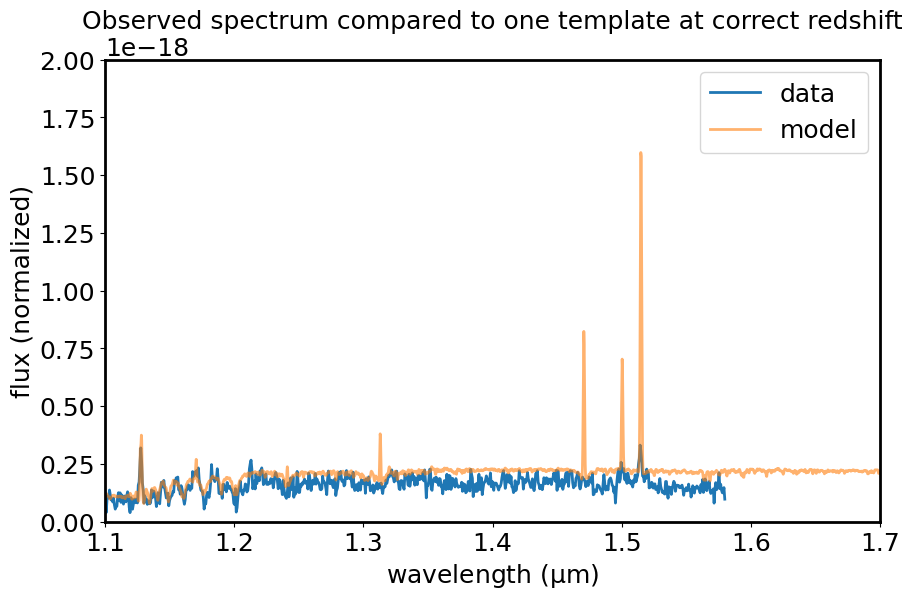

In [53]:
# Take a look at the observed spectrum and one of the templates at the correct redshift
mean_obs = np.mean(spec1d_masked_flamb_unc.flux)
mean_temp = np.mean(templatelist[0].flux)
temp_for_plot = Spectrum1D(spectral_axis=templatelist[0].spectral_axis * (1.+zz),
                           flux=templatelist[0].flux*mean_obs/mean_temp)

plt.figure(figsize=[10, 6])
plt.plot(spec1d_masked_flamb_unc.spectral_axis, spec1d_masked_flamb_unc.flux, label='data')
plt.plot(temp_for_plot.spectral_axis, temp_for_plot.flux, label='model', alpha=0.6)
plt.xlabel("wavelength ({:latex})".format(spec1d_masked_flamb_unc.spectral_axis.unit))
plt.ylabel("flux (normalized)")
plt.xlim(1.1, 1.7)
plt.ylim(0, 2e-18)
plt.legend()
plt.title("Observed spectrum compared to one template at correct redshift")
plt.show()

In [54]:
tm_results = template_comparison.template_match(observed_spectrum=spec1d_masked_flamb_unc, 
                                                spectral_templates=templatelist, 
                                                resample_method="flux_conserving", 
                                                redshift=zz)
tm_results[0]

<Spectrum1D(flux=<Quantity [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           1.86314806e-22, 1.84870505e-22, 1.83426204e-22] erg / (Angstrom s cm2)>, spectral_axis=<SpectralAxis [ 0.03046779,  0.0307401 ,  0.0310124 , ..., 29.34832   , 29.469344  ,
   29.590368  ] um>)>

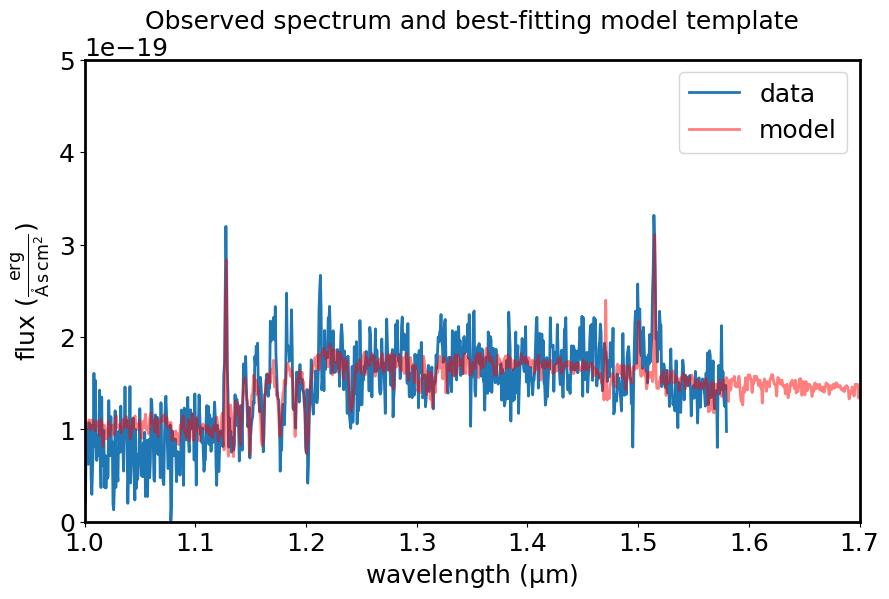

In [55]:
plt.figure(figsize=[10, 6])
plt.plot(spec1d_masked_flamb_unc.spectral_axis, spec1d_masked_flamb_unc.flux, label="data")
plt.plot(tm_results[0].spectral_axis, tm_results[0].flux, color='r', alpha=0.5, label='model')
plt.xlim(1.0, 1.7)
plt.ylim(0, 5e-19)
plt.xlabel("wavelength ({:latex})".format(spec1d_masked_flamb_unc.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_masked_flamb_unc.flux.unit))
plt.legend()
plt.title("Observed spectrum and best-fitting model template")
plt.show()

## New instance of Specviz with spectrum and template
Passing the spectra with different (but compatible) units. Specviz adopts the first and converts the second spectrum appropriately.

In [56]:
specviz_2 = Specviz()
specviz_2.load_data(spec1d_masked, data_label='observed') # This is in MJy
specviz_2.load_data(tm_results[0], data_label='model') # This is in erg/(s cm^2 A)
specviz_2.show()

Application(config='specviz', docs_link='https://jdaviz.readthedocs.io/en/v3.7.0/specviz/index.html', events=[…

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>

Notebook created by Camilla Pacifici (cpacifici@stsci.edu)<br>
Updated on September 14, 2023